In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lifelines import KaplanMeierFitter, CoxPHFitter

np.random.seed(42)


In [6]:
users = pd.read_csv("datadesign/users.csv")
churn = pd.read_csv("datadesign/churn.csv")
revenue = pd.read_csv("datadesign/revenue.csv")
channels = pd.read_csv("datadesign/channel_exposure.csv")


In [7]:
df = (
    users
    .merge(churn, on="user_id")
    .merge(channels[["user_id", "cost"]], on="user_id")
)

df.head()


,user_id,age,income_band,risk_score,channel,converted,observed_months,churned,cost
0,0,56,low,0.404887,social_ads,0,24.0,0,1.777098
1,1,46,low,0.271536,affiliate,1,24.0,0,2.191188
2,2,32,low,0.360160,paid_search,0,24.0,0,3.052957
3,3,60,low,0.407633,social_ads,1,24.0,0,1.650550
4,4,25,mid,0.556474,organic,1,24.0,0,0.175349


In [8]:
df.groupby("channel")["churned"].mean().sort_values()


channel
referral       0.212418
organic        0.222901
paid_search    0.316401
affiliate      0.339123
social_ads     0.358643
Name: churned, dtype: float64

In [9]:
revenue.groupby("user_id")["revenue"].sum().describe()


count    26552.000000
mean       653.826601
std        422.405652
min          5.000000
25%        292.640884
50%        622.123495
75%        915.183089
max       1578.360853
Name: revenue, dtype: float64

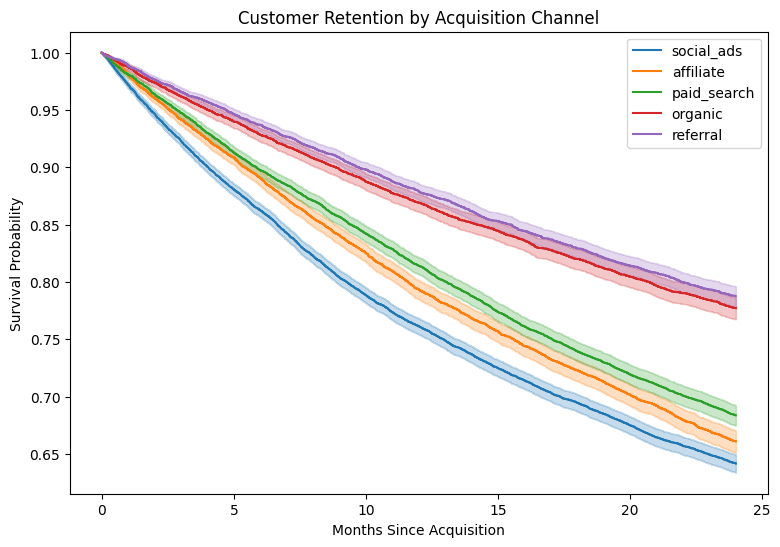

In [10]:
plt.figure(figsize=(9,6))

kmf = KaplanMeierFitter()

for channel in df["channel"].unique():
    subset = df[df["channel"] == channel]
    kmf.fit(
        durations=subset["observed_months"],
        event_observed=subset["churned"],
        label=channel
    )
    kmf.plot_survival_function()

plt.title("Customer Retention by Acquisition Channel")
plt.xlabel("Months Since Acquisition")
plt.ylabel("Survival Probability")
plt.show()


In [11]:
survival_df = df[
    ["observed_months", "churned", "age", "risk_score", "channel"]
]

survival_df = pd.get_dummies(
    survival_df,
    columns=["channel"],
    drop_first=True
)


In [12]:
cph = CoxPHFitter()
cph.fit(
    survival_df,
    duration_col="observed_months",
    event_col="churned"
)

cph.print_summary()


<lifelines.CoxPHFitter: fitted with 50000 total observations, 34918 right-censored observations>
             duration col = 'observed_months'
                event col = 'churned'
      baseline estimation = breslow
   number of observations = 50000
number of events observed = 15082
   partial log-likelihood = -159735.85
         time fit was run = 2025-12-25 06:11:57 UTC

---
                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                            
age                 -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
risk_score          -1.57      0.21      0.05           -1.67           -1.46                0.19                0.23
channel_organic     -0.40      0.67      0.03           -0.46           -0.34                0.63                0.71
channel_paid_search -0.08      0.93      0.02           -0.13           -0.03                0.88                0.97
channel_referral    -0.56      0.57      0.03           -0.62           -0.50                0.54                0.61
channel_social_ads   0.19      1.21      0.02            0.14            0.23                1.15                1.26

                     cmp to      z      p  -log2(p)
covariate                                          
age                    0.00  -2.29   0.02      5.51
risk_score             0.00 -30.02 <0.005    655.44
channel_organic        0.00 -13.15 <0.005    128.71
channel_paid_search    0.00  -3.07 <0.005      8.88
channel_referral       0.00 -18.78 <0.005    258.99
channel_social_ads     0.00   8.19 <0.005     51.72
---
Concordance = 0.60
Partial AIC = 319483.71
log-likelihood ratio test = 1805.00 on 6 df
-log2(p) of ll-ratio test = inf

In [13]:
df["expected_lifetime"] = cph.predict_expectation(survival_df)


In [14]:
df.groupby("channel")["expected_lifetime"].mean().sort_values(ascending=False)


channel
referral       21.137821
organic        20.976314
paid_search    19.650292
affiliate      19.320544
social_ads     18.922628
Name: expected_lifetime, dtype: float64

In [15]:
user_revenue = (
    revenue
    .groupby("user_id")["revenue"]
    .mean()
    .reset_index(name="avg_monthly_revenue")
)

df = df.merge(user_revenue, on="user_id", how="left")
df["avg_monthly_revenue"].fillna(0, inplace=True)


/var/folders/c1/n3rtprk17jj54dgqz_4lbsyc0000gn/T/ipykernel_41757/3269382973.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["avg_monthly_revenue"].fillna(0, inplace=True)


In [16]:
DISCOUNT_RATE = 0.01  # monthly

df["ltv"] = (
    df["avg_monthly_revenue"]
    * df["expected_lifetime"]
    / (1 + DISCOUNT_RATE)
)


In [17]:
channel_ltv = (
    df.groupby("channel")
    .agg(
        avg_ltv=("ltv", "mean"),
        avg_lifetime=("expected_lifetime", "mean"),
        avg_cost=("cost", "mean")
    )
    .sort_values("avg_ltv", ascending=False)
)

channel_ltv


,avg_ltv,avg_lifetime,avg_cost
channel,,,
referral,765.637162,21.137821,1.002913
paid_search,441.245015,19.650292,2.997953
affiliate,388.577997,19.320544,2.496420
organic,258.435589,20.976314,0.200189
social_ads,217.228852,18.922628,2.000272


In [18]:
uplift_results = pd.read_csv('datadesign/uplift_results.csv')

In [19]:
uplift_results.head()

,user_id,age,income_band,risk_score,channel_x,converted,channel_y,exposed,cost,treatment,uplift,conversion_rate
0,0,56,low,0.404887,social_ads,0,social_ads,1,1.777098,0,-0.042967,0
1,1,46,low,0.271536,affiliate,1,affiliate,1,2.191188,0,0.024612,1
2,2,32,low,0.360160,paid_search,0,paid_search,1,3.052957,0,0.085478,0
3,3,60,low,0.407633,social_ads,1,social_ads,1,1.650550,0,-0.022671,1
4,4,25,mid,0.556474,organic,1,organic,1,0.175349,0,0.054585,1


In [20]:
df.head()

,user_id,age,income_band,risk_score,channel,converted,observed_months,churned,cost,expected_lifetime,avg_monthly_revenue,ltv
0,0,56,low,0.404887,social_ads,0,24.0,0,1.777098,18.198173,0.000000,0.000000
1,1,46,low,0.271536,affiliate,1,24.0,0,2.191188,18.027970,35.748675,638.095104
2,2,32,low,0.360160,paid_search,0,24.0,0,3.052957,18.935395,0.000000,0.000000
3,3,60,low,0.407633,social_ads,1,24.0,0,1.650550,18.245334,23.939868,432.466235
4,4,25,mid,0.556474,organic,1,24.0,0,0.175349,21.093467,33.042680,690.083850


In [25]:
df = df.merge(uplift_results, how = 'inner', on= 'user_id').copy()

In [28]:
df.columns

Index(['user_id', 'age_x', 'income_band_x', 'risk_score_x', 'channel',
       'converted_x', 'observed_months', 'churned', 'cost_x',
       'expected_lifetime', 'avg_monthly_revenue', 'ltv', 'age_y',
       'income_band_y', 'risk_score_y', 'channel_x', 'converted_y',
       'channel_y', 'exposed', 'cost_y', 'treatment', 'uplift',
       'conversion_rate', 'incremental_ltv'],
      dtype='object')

In [26]:
# assuming df already contains 'uplift'
df["incremental_ltv"] = df["uplift"] * df["ltv"]


In [29]:
incremental_value = (
    df.groupby("channel")
    .agg(
        incremental_ltv=("incremental_ltv", "mean"),
        avg_cost=("cost_x", "mean")
    )
    .sort_values("incremental_ltv", ascending=False)
)

incremental_value


,incremental_ltv,avg_cost
channel,,
referral,21.220446,1.002913
paid_search,14.959840,2.997953
affiliate,10.564800,2.496420
organic,6.936259,0.200189
social_ads,5.622442,2.000272


In [30]:
incremental_value.reset_index()

,channel,incremental_ltv,avg_cost
0,referral,21.220446,1.002913
1,paid_search,14.959840,2.997953
2,affiliate,10.564800,2.496420
3,organic,6.936259,0.200189
4,social_ads,5.622442,2.000272


In [31]:
incremental_value.reset_index().to_csv('datadesign/incremental_ltv_results.csv', index = False)